In [1]:
%load_ext autoreload
import os.path as op

from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
from scipy.signal import spectrogram
from scipy.fft import ifft, fft
from scipy.stats import ttest_rel

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from fooof import FOOOFGroup, FOOOF

from timescales.est.psd import fit_psd, convert_knee_val
from timescales.est.acf import ACF, fit_acf, fit_acf_cos, compute_acf
from timescales.sim.acf import sim_acf_cos, sim_exp_decay
from timescales.plts import plot_connected_scatter

from sklearn.cluster import KMeans

### Sliding Window Tau

#### Background
This notebook uses fcx-1, from CRCNS, to investigate sliding window tau estimation. This data consists of two cycles, each with ~7 minutes of wake followed by ~20 minutes of sleep. Based on Watson at al. 2016, they show that overall power increases, corresponding to low variance voltage segments, are associated with non-REM episodes. CRCNS provides times of sleep, non-rem, rem, and micro-arousals. Here, we focus on comparing timescales between sleep vs non-rem, since rem and micro arousals periods contain much less data.


#### Method / Results
For the ~54 minutes of interest, a window is slide across the data, with a step size of 1s. Each window contains 5s before and 5s after the current sample. Windows are grouped by wake and non-REM sleep periods. A PSD is computed for each window, and a timescale is determined. The results show that short timescales are associate with non-REM periods and long timescales are associated with wake periods.

#### Discussion
The wake periods tend to have short timescales, but also have lower r-squared values, compared to the non-REM periods. This may mean that there is more noise during the wake periods (i.e. noise from movement) and/or that the Lorenztian isn't the appriopriate model.

Many of the wake timescales appear to be > 1s long (< 1 Hz) and Welch's doesn't provide resolution below 1 Hz which may be something to also consider.

#### Reference
Network Homeostasis and State Dynamics of Neocortical Sleep. Watson BO, Levenstein D, Greene JP, Gelinas JN, Buzsáki G.; Neuron. 2016 Apr 27. pii: S0896-6273(16)30056-3. doi: 10.1016/j.neuron.2016.03.036

In [2]:
def create_windows(samples, win_len, win_spacing):
    # Determine windows
    win_starts = []

    for lower, upper in samples:
        win_starts.append(np.arange(lower-1, upper, win_spacing) - (win_len//2))

    win_starts = np.concatenate(win_starts)
    mids = win_starts + (win_len//2)

    return win_starts, mids

def sort_result(result):
    taus = np.array([r[0] for r in result])
    rsq = np.array([r[1] for r in result])
    result_class = [r[2] for r in result]
    return taus, rsq, result_class

# Multi-processing compatible wrappers
def _fit_psd(s, sig_lfp=None, fs=None, win_len=None, compute_spectrum_kwargs=None,
              f_range=None, knee_bounds=None, fooof_init=None, rsq_type='linear'):
                    
    if compute_spectrum_kwargs is None:
        compute_spectrum_kwargs = {}
        
    freqs, powers = compute_spectrum(sig_lfp[s:s+win_len], fs, f_range=f_range,
                                     **compute_spectrum_kwargs)
                    
    if fooof_init is None:
        fooof_init = dict(max_n_peaks=5, peak_threshold=3,
                          peak_width_limits=(2, 10))
    
    fm, _, kt = fit_psd(freqs, powers, f_range, fooof_init=fooof_init,
                        knee_bounds=knee_bounds, n_jobs=1)
    
    if rsq_type == 'log':
        rsq = fm.r_squared_
    elif rsq_type == 'linear':
        rsq = np.corrcoef(10**fm.power_spectrum, 10**fm.fooofed_spectrum_)[0][1] ** 2
    
    return kt, rsq, fm

def _fit_acf(iterable, sig_lfp=None, fs=None, win_len=None,
             lags=None, nlags=None, method='cos', from_psd=False, 
             compute_spectrum_kwargs=None, **fit_kwargs):
    
    if sig_lfp is not None:
        _acf = ACF()
        _acf.compute_acf(sig_lfp, fs, iterable, win_len, nlags, from_psd, compute_spectrum_kwargs)
    elif sig_lfp is None:
        _acf = ACF(iterable, lags, fs)

    if method == 'cos':
        _acf.fit_cos(**fit_kwargs)
    elif method == 'decay':
        _acf.fit(**fit_kwargs)

    if np.isnan(_acf.params).any():
        return np.nan, np.nan, _acf
        
    return _acf.params[0], _acf.rsq, _acf

In [3]:
# Load LFP
data_dir = '/home/rph/Projects/timescale-methods/fcx1/data_mats'
lfp_file = op.join(data_dir, 'data18.mat')

fs = 1250
sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = normalize_sig(sig_lfp, mean=0, variance=1)
times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Extract behavioral data
beh_file = op.join(data_dir, '20140526_277um_WSRestrictedIntervals.mat')

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

### SpecParam

In [4]:
# Settings
win_len = int(20*fs)+1
win_spacing = int(fs * 10)

# Remove edges to reduce edge trial edge effects
wake_pad = wake.copy()
wake_pad[:, 0] = wake_pad[:, 0] + win_len
wake_pad[:, 1] = wake_pad[:, 1] - win_len

nrem_pad = nrem.copy()
nrem_pad[:, 0] = nrem_pad[:, 0] + win_len
nrem_pad[:, 1] = nrem_pad[:, 1] - win_len

# Create spectral windows
wake_starts, wake_mids = create_windows(wake_pad, win_len, win_spacing)
nrem_starts, nrem_mids = create_windows(nrem_pad, win_len, win_spacing)

In [5]:
# SpecParam: Wake
fit_kwargs = dict(
    sig_lfp=sig_lfp, fs=fs, win_len=win_len, f_range=(0, 80),
    compute_spectrum_kwargs=dict(nperseg=int(2*fs), avg_type='mean'),
    knee_bounds=(.05, 100000), rsq_type='linear'
)

with Pool(processes=6) as pool:
    mapping = pool.imap(partial(_fit_psd, **fit_kwargs), wake_starts, chunksize=20)
    results_wake = list(tqdm(mapping, total=len(wake_starts), dynamic_ncols=True))
    
# SpecParam: Non-REM
fit_kwargs = dict(
    sig_lfp=sig_lfp, fs=fs, win_len=win_len, f_range=(0, 80),
    compute_spectrum_kwargs=dict(nperseg=int(2*fs), avg_type='mean'),
    knee_bounds=(.05, 100000), rsq_type='linear'
)

with Pool(processes=6) as pool:
    mapping = pool.imap(partial(_fit_psd, **fit_kwargs), nrem_starts, chunksize=20)
    results_nrem = list(tqdm(mapping, total=len(nrem_starts), dynamic_ncols=True))
    
# Sort results
wake_taus, wake_rsq, wake_fms = sort_result(results_wake)
nrem_taus, nrem_rsq, nrem_fms = sort_result(results_nrem)

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

### ACF

In [6]:
# Computing the autocorrelation using ifft(psd)
#   avoids issues arising from very low frequency oscillations
# This also allows better direct comparisons of the two methods

psds_wake = np.array([10**i.power_spectrum for i in wake_fms])
psds_nrem = np.array([10**i.power_spectrum for i in nrem_fms])
freqs = np.array(wake_fms[0].freqs)

corrs_wake = ifft(psds_wake).real
corrs_wake = corrs_wake[:, :len(corrs_wake[0])//2]

corrs_nrem = ifft(psds_nrem).real
corrs_nrem = corrs_nrem[:, :len(corrs_nrem[0])//2]

lags = np.arange(0, int(len(corrs_wake[0])*2), 2)

# ACF: Wake
fit_kwargs = dict(lags=lags, fs=fs, win_len=win_len, nlags=int(10*fs),
                  method='cos', maxfev=1000)

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, **fit_kwargs), corrs_wake, chunksize=20)
    results_wake_acf = list(tqdm(mapping, total=len(corrs_wake), dynamic_ncols=True))    

# ACF: Non-REM
fit_kwargs = dict(lags=lags, fs=fs, win_len=win_len, nlags=int(10*fs),
                  method='cos', maxfev=1000)

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, **fit_kwargs), corrs_nrem, chunksize=20)
    results_nrem_acf = list(tqdm(mapping, total=len(corrs_nrem), dynamic_ncols=True))
    
# Sort Results
wake_taus_acf, wake_rsq_acf, wake_acf_class = sort_result(results_wake_acf)
nrem_taus_acf, nrem_rsq_acf, nrem_acf_class = sort_result(results_nrem_acf)

  0%|          | 0/207 [00:00<?, ?it/s]

Process ForkPoolWorker-20:
Process ForkPoolWorker-18:
Process ForkPoolWorker-19:


KeyboardInterrupt: 

In [ ]:
# ACF: Wake
fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, nlags=int(5 * fs),
                  method='cos', maxfev=10000)

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, **fit_kwargs), wake_starts, chunksize=20)
    results_wake_acf = list(tqdm(mapping, total=len(wake_starts), dynamic_ncols=True))    

# ACF: Non-REM
fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, nlags=int(5 * fs),
                  method='cos', maxfev=10000, bounds=bounds)

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, **fit_kwargs), nrem_starts, chunksize=20)
    results_nrem_acf = list(tqdm(mapping, total=len(nrem_starts), dynamic_ncols=True))
    
# Sort Results
wake_taus_acf, wake_rsq_acf, wake_acf_class = sort_result(results_wake_acf)
nrem_taus_acf, nrem_rsq_acf, nrem_acf_class = sort_result(results_nrem_acf)

In [7]:
from_psd = True
compute_spectrum_kwargs=dict(method='welch', nperseg=int(2*fs), avg_type='mean')
                             
# ACF: Wake
fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, nlags=int(5* fs),
                  method='cos', maxfev=10000)

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, from_psd=from_psd, compute_spectrum_kwargs=compute_spectrum_kwargs, **fit_kwargs),
                        wake_starts, chunksize=20)
    results_wake_acf = list(tqdm(mapping, total=len(wake_starts), dynamic_ncols=True))    

# ACF: Non-REM
fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, nlags=int(5 * fs),
                  method='cos', maxfev=10000)

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, from_psd=from_psd, compute_spectrum_kwargs=compute_spectrum_kwargs, **fit_kwargs),
                        nrem_starts, chunksize=20)
    results_nrem_acf = list(tqdm(mapping, total=len(nrem_starts), dynamic_ncols=True))
    
# Sort Results
wake_taus_acf, wake_rsq_acf, wake_acf_class = sort_result(results_wake_acf)
nrem_taus_acf, nrem_rsq_acf, nrem_acf_class = sort_result(results_nrem_acf)

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

### Results

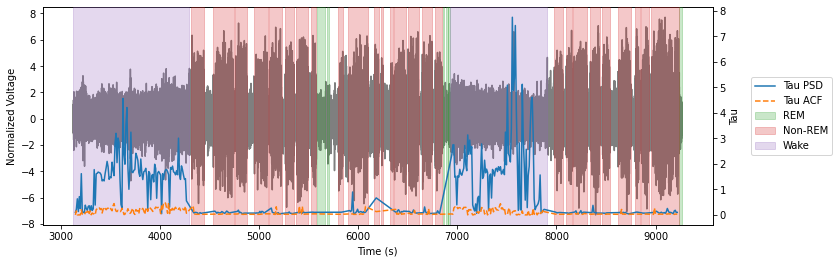

In [8]:
# Determine start and end of lfp
start_ends = [nrem[0][0], nrem[-1][-1], rem[0][0],
              rem[-1][-1], wake[0][0], wake[-1][-1]]

start = min(start_ends)-1
end = max(start_ends)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Normalized Voltage')
ax1.plot(times[start:end], sig_lfp[start:end], label='LFP', color='k', alpha=.5)
ax1.tick_params(axis='y', labelcolor='k')

mids = np.concatenate((wake_mids, nrem_mids)).astype(int)
taus_psd = np.concatenate((wake_taus, nrem_taus))
taus_acf = np.concatenate((wake_taus_acf, nrem_taus_acf))
order = np.argsort(mids)

ax2 = ax1.twinx()
ax2.set_ylabel('Tau')
ax2.plot(times[mids[order]], taus_psd[order], alpha=1, label='Tau PSD', color='C0', zorder=10)
ax2.plot(times[mids[order]], taus_acf[order], alpha=1, label='Tau ACF', color='C1', zorder=10, ls='--')
ax2.tick_params(axis='y')

# Color regions
colors = ['C2', 'C3', 'C4']
labels = ['REM', 'Non-REM', 'Wake']

for periods, color, label in zip([rem, nrem, wake], colors, labels):
    for _ind, i in enumerate(periods):
        if _ind == 0:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3, label=label)
        else:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3)

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5));

In [9]:
# Remove outliers
n_to_keep= round(len(wake_rsq)*1)
wake_keep = np.argsort(np.abs(wake_taus - wake_taus_acf))[:n_to_keep]

n_to_keep= round(len(nrem_rsq)*1)
nrem_keep = np.argsort(np.abs(nrem_taus - nrem_taus_acf))[:n_to_keep]

# Run paired t-test
wake_rsq_pval = ttest_rel(wake_rsq[wake_keep], wake_rsq_acf[wake_keep]).pvalue
wake_taus_pval = ttest_rel(wake_taus[wake_keep], wake_taus_acf[wake_keep]).pvalue

nrem_rsq_pval = ttest_rel(nrem_rsq[nrem_keep], nrem_rsq_acf[nrem_keep]).pvalue
nrem_taus_pval = ttest_rel(nrem_taus[nrem_keep], nrem_taus_acf[nrem_keep]).pvalue

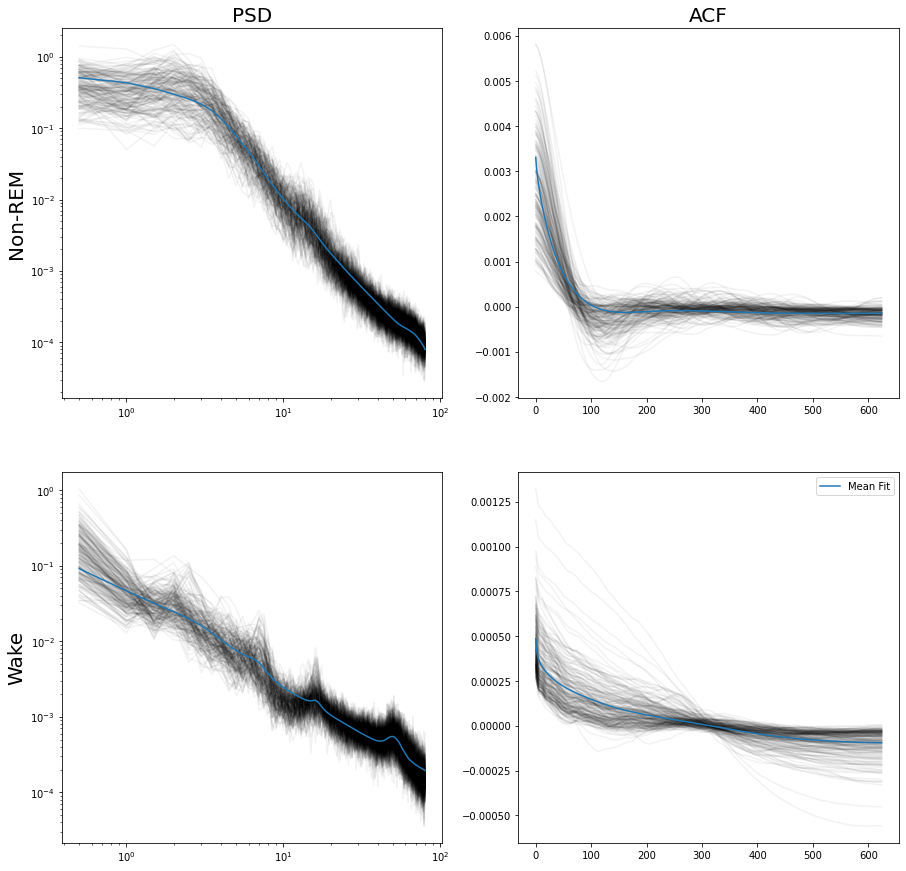

In [10]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

for _fm in nrem_fms:
    axes[0][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)
    
axes[0][0].plot(_fm.freqs, np.mean(np.array([10**i.fooofed_spectrum_ for i in nrem_fms]), axis=0),
                color='C0')

for _fm in wake_fms:
    axes[1][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)
    
axes[1][0].plot(_fm.freqs, np.mean(np.array([10**i.fooofed_spectrum_ for i in wake_fms]), axis=0),
                color='C0')

for i, _acf in enumerate(np.array([i.corrs for i in nrem_acf_class])):
    axes[0][1].plot(_acf, color='k', alpha=.05)
    
axes[0][1].plot(np.mean(np.array([i.corrs_fit for i in nrem_acf_class]), axis=0), color='C0')

for i, _acf in enumerate(np.array([i.corrs for i in wake_acf_class])):
    axes[1][1].plot(_acf, color='k', alpha=.05)
    
axes[1][1].plot(np.mean(np.array([i.corrs_fit for i in wake_acf_class]), axis=0), color='C0', label='Mean Fit')
    
axes[0][0].set_title('PSD', size=20)
axes[0][1].set_title('ACF', size=20)
axes[0][0].set_ylabel('Non-REM', size=20)
axes[1][0].set_ylabel('Wake', size=20)

plt.legend();

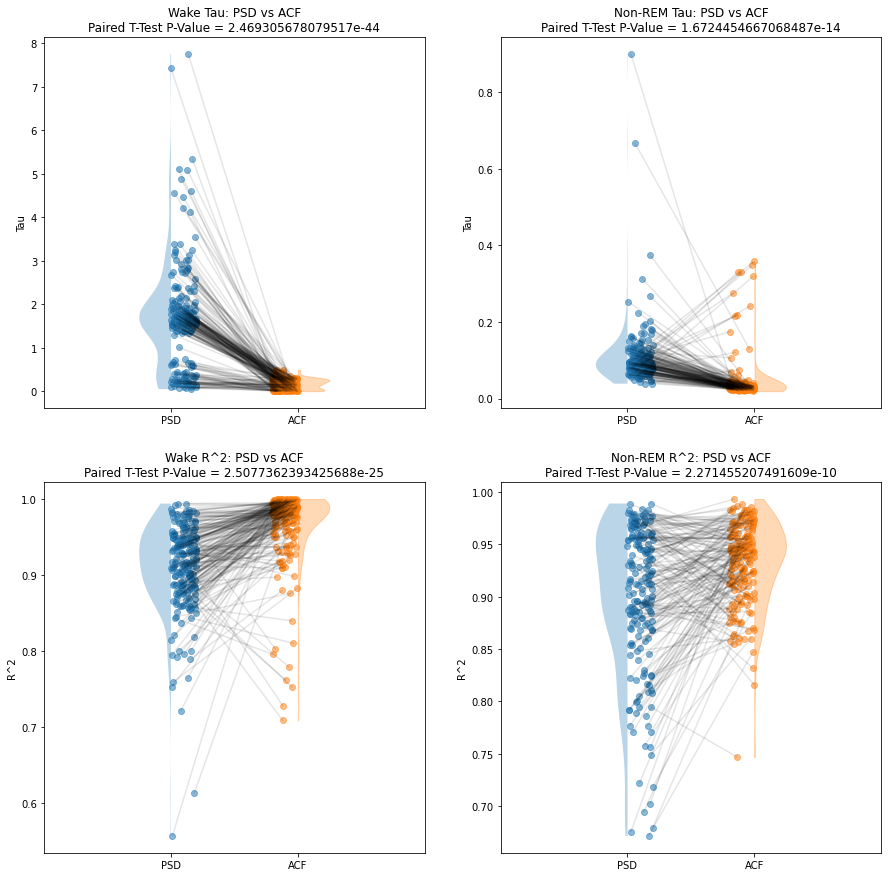

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus, wake_taus_acf, axes[0][0], 
                       f'Wake Tau: PSD vs ACF\nPaired T-Test P-Value = {wake_taus_pval}')

plot_connected_scatter(nrem_taus, nrem_taus_acf, axes[0][1],
                       f'Non-REM Tau: PSD vs ACF\nPaired T-Test P-Value = {nrem_taus_pval}')

plot_connected_scatter(wake_rsq, wake_rsq_acf, axes[1][0],
                       title=f'Wake R^2: PSD vs ACF\nPaired T-Test P-Value = {wake_rsq_pval}',
                       ylabel='R^2')

plot_connected_scatter(nrem_rsq, nrem_rsq_acf, axes[1][1],
                       title=f'Non-REM R^2: PSD vs ACF\nPaired T-Test P-Value = {nrem_rsq_pval}',
                       ylabel='R^2')

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus[wake_keep], nrem_taus[nrem_keep], axes[0][0], 
                       f'=PSD Taus\nPaired T-Test P-Value = {wake_taus_pval}',
                       ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_taus_acf[wake_keep], nrem_taus_acf[nrem_keep], axes[0][1],
                       f'=ACF Taus\nPaired T-Test P-Value = {nrem_taus_pval}',
                       ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_rsq[wake_keep], nrem_rsq[nrem_keep], axes[1][0],
                       title=f'PSD R^2\nPaired T-Test P-Value = {wake_rsq_pval}',
                       ylabel='R^2', ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_rsq_acf[wake_keep], nrem_rsq_acf[nrem_keep], axes[1][1],
                       title=f'ACF R^2\nPaired T-Test P-Value = {nrem_rsq_pval}',
                       ylabel='R^2', ticklabels=['Wake', 'Non-REM'], paired=False)

### Predictive Analysis
Since ground truth is unknown for the timescales, the best we can do to validate is to use estimated timescales to predict whether the mouse is awake or in non-rem sleep. 

In [12]:
import warnings

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

In [13]:
def train_test(features, labels, grid=None, rand_searches=None, rand_seed=None,  n_jobs=-1):
    """Train/test model using nested k-folds paradigm.
    Parameters
    ----------
    features : 2d array
        Features to use for training/testing of shape (n_samples, n_features).
    labels : list
        Defines groups for binary classification.
    grid : dict, optional, default: None
        SVM parameters to grid seach. If not, the default grid is:
        dict(kernel='rbf', gamma='auto', C=2**C for C in range(-5, 16)])
    rand_search : int, optional, default: False
        The number of random search iterations to run as an alternative to the default exhaustive
        search. Useful for large grids.
    rand_seed : int, optional, default: None
        Random seed for train/test splitting. Use for reproducible results.
    n_jobs : int, optional, default: -1
        Number of parameters combinations to run in parallel during grid search.
    Returns
    -------
    df_performance : pd.DataFrame
        Hyperparameters and performance across folds.
    y_test_plot : list
        Test labels for each fold (for plotting performance).
    probas_plot : list
        Prediction probabilites (for plotting performance).
    """
    warnings.filterwarnings("ignore")

    # Log performance
    col_header = ['Kernel', 'Gamma', 'Cost', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
    df_performance = pd.DataFrame(columns=col_header)

    # Plotting
    y_test_plot = []
    probas_plot = []

    # Define grid hyper-parameters
    tuned_parameters = dict(
        kernel = ['rbf'], #kernel = ['rbf', 'sigmoid', 'poly'],
        gamma = ['auto'], #gamma = [2**g for g in range(-15, 4)],
        C = [2**C for C in range(-5, 16)]
    )

    # Cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_seed)
    inner_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=rand_seed)
    for idx, (train_idx, test_idx) in tqdm(enumerate(kfold.split(features, labels)), total=10):

        # Split data
        x_train = [features[idx] for idx in train_idx]
        y_train = [labels[idx] for idx in train_idx]
        x_test = [features[idx] for idx in test_idx]
        y_test = [labels[idx] for idx in test_idx]

        # Apply mean and variance centering
        scaler = StandardScaler().fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        # Pipe feature selection and classifier together
        svc = SVC(class_weight='balanced', probability=True)

        # Train model
        if rand_searches is None:
            # Exhaustive grid search
            clf = GridSearchCV(svc, tuned_parameters, scoring='balanced_accuracy',
                           n_jobs=n_jobs, cv=inner_kfold)
        else:
            # Randomized search for large grids
            clf = RandomizedSearchCV(svc, tuned_parameters, n_iter=rand_searches,
                                     scoring='balanced_accuracy', n_jobs=n_jobs, cv=inner_kfold)

        # Train
        clf.fit(x_train, y_train)

        # Test
        y_true, y_pred = y_test, clf.predict(x_test)

        # Evaluate
        sensitivity, specificity, ppv, npv = eval_performance(y_true, y_pred)

        # Append performance to df
        row = [clf.best_params_['kernel'], clf.best_params_['gamma'],
               clf.best_params_['C'], sensitivity, specificity, ppv, npv]

        df_performance = df_performance.append(pd.Series(row, index=df_performance.columns),
                                               ignore_index=True)

        # For plotting ROC
        y_test_plot.append(y_test)
        probas_plot.append(clf.predict_proba(x_test))

    return df_performance, y_test_plot, probas_plot

def eval_performance(y_true, y_pred):
    """Determine true/false positive/negative rates."""

    # Evaluate performance
    tp, tn, fp, fn = [], [], [], []

    for idx, y in enumerate(y_true):
        if y == 1.0 and y == y_pred[idx]:
            tp.append(1)
        elif y == 1.0 and y != y_pred[idx]:
            fn.append(1)
        elif y == 0.0 and y == y_pred[idx]:
            tn.append(1)
        elif y == 0.0 and y != y_pred[idx]:
            fp.append(1)

    if len(fp) != 0 and len(fn) != 0:
        # This is most likely
        sensitivity = len(tp)/(len(tp)+len(fn))
        specificity = len(tn)/(len(tn)+len(fp))
        ppv = len(tp)/(len(tp)+len(fp))
        npv = len(tn)/(len(tn)+len(fn))
    elif len(fp) != 0 and len(fn) == 0:
        # Likely overfitting
        sensitivity = 1
        specificity = len(tn)/(len(tn)+len(fp))
        ppv = len(tp)/(len(tp)+len(fp))
        npv = 1
    elif len(fp) == 0 and len(fn) != 0:
        # Likely overfitting
        sensitivity = len(tp)/(len(tp)+len(fn))
        specificity = 1
        ppv = 1
        npv = len(tn)/(len(tn)+len(fn))
    if len(fp) == 0 and len(fn) == 0:
        # Perfect classification
        sensitivity = 1
        specificity = 1
        ppv = 1
        npv = 1

    return sensitivity, specificity, ppv, npv

def plot_roc(probas_list, y_test_list):
    """Plot ROC and AUC of classifier performance.
    Parameters
    ----------
    probas_list : list
        Prediction probabilities for each outer fold.
    y_test_list : list
        Labels in each outter fold test split.
    """

    # Results visulazation
    plt.figure(figsize=(10,10), dpi=500)

    # ROC for each fold
    tprs = []
    aucs = []
    for idx, probas in enumerate(probas_list):
        mean_fpr = np.linspace(0, 1, 100)
        fpr, tpr, thresholds = roc_curve(y_test_list[idx], probas[:, 1])

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC Fold %d (AUC = %0.2f)' % (idx+1, roc_auc))

    # Mean ROC and confidence interval
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 Standard Deviation')

    # Chance
    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")

    # Graph Labels
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
features_psd = np.hstack((wake_taus, nrem_taus))
features_acf = np.hstack((wake_taus_acf, nrem_taus_acf))

labels = np.hstack((np.zeros(len(wake_taus)), np.ones(len(nrem_taus))))

In [15]:
# Train and test classifier
df_performance_psd, y_test_psd, probas_psd = train_test(np.array([features_psd]).T, labels, rand_seed=1)

df_performance_acf, y_test_acf, probas_acf = train_test(np.array([features_acf]).T, labels, rand_seed=1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

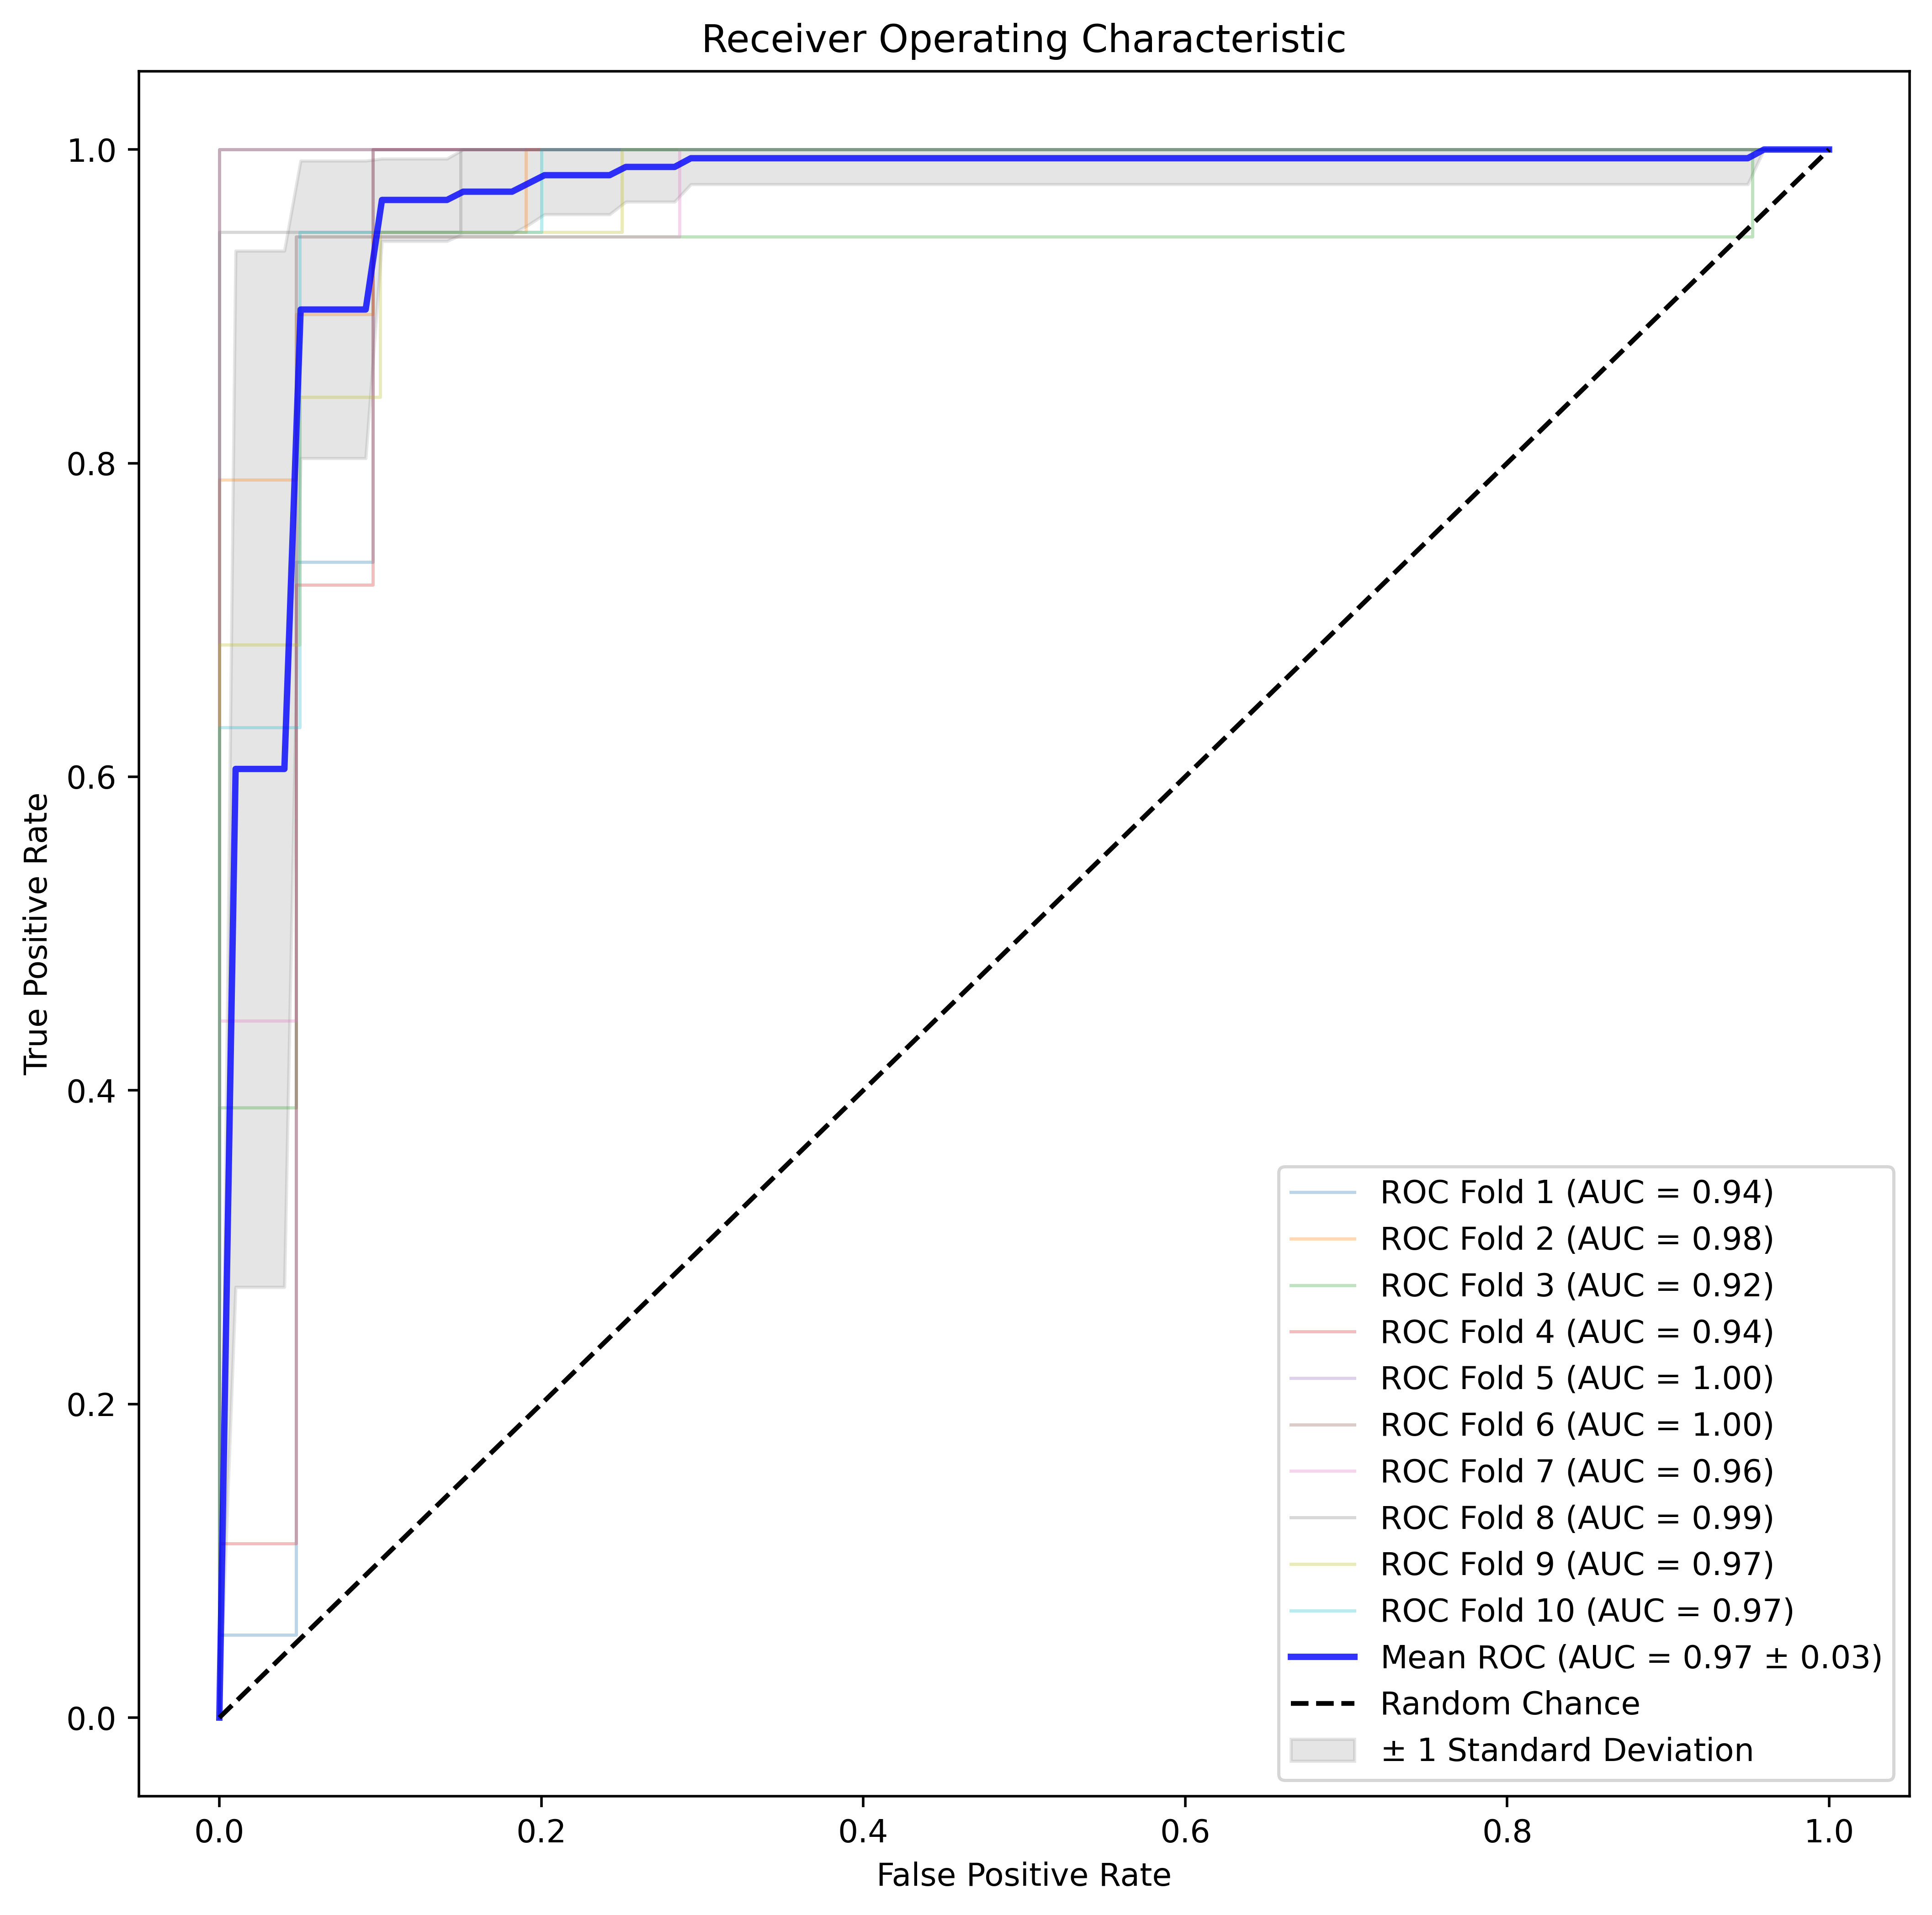

In [16]:
# Plot roc/auc
plot_roc(probas_psd, y_test_psd)

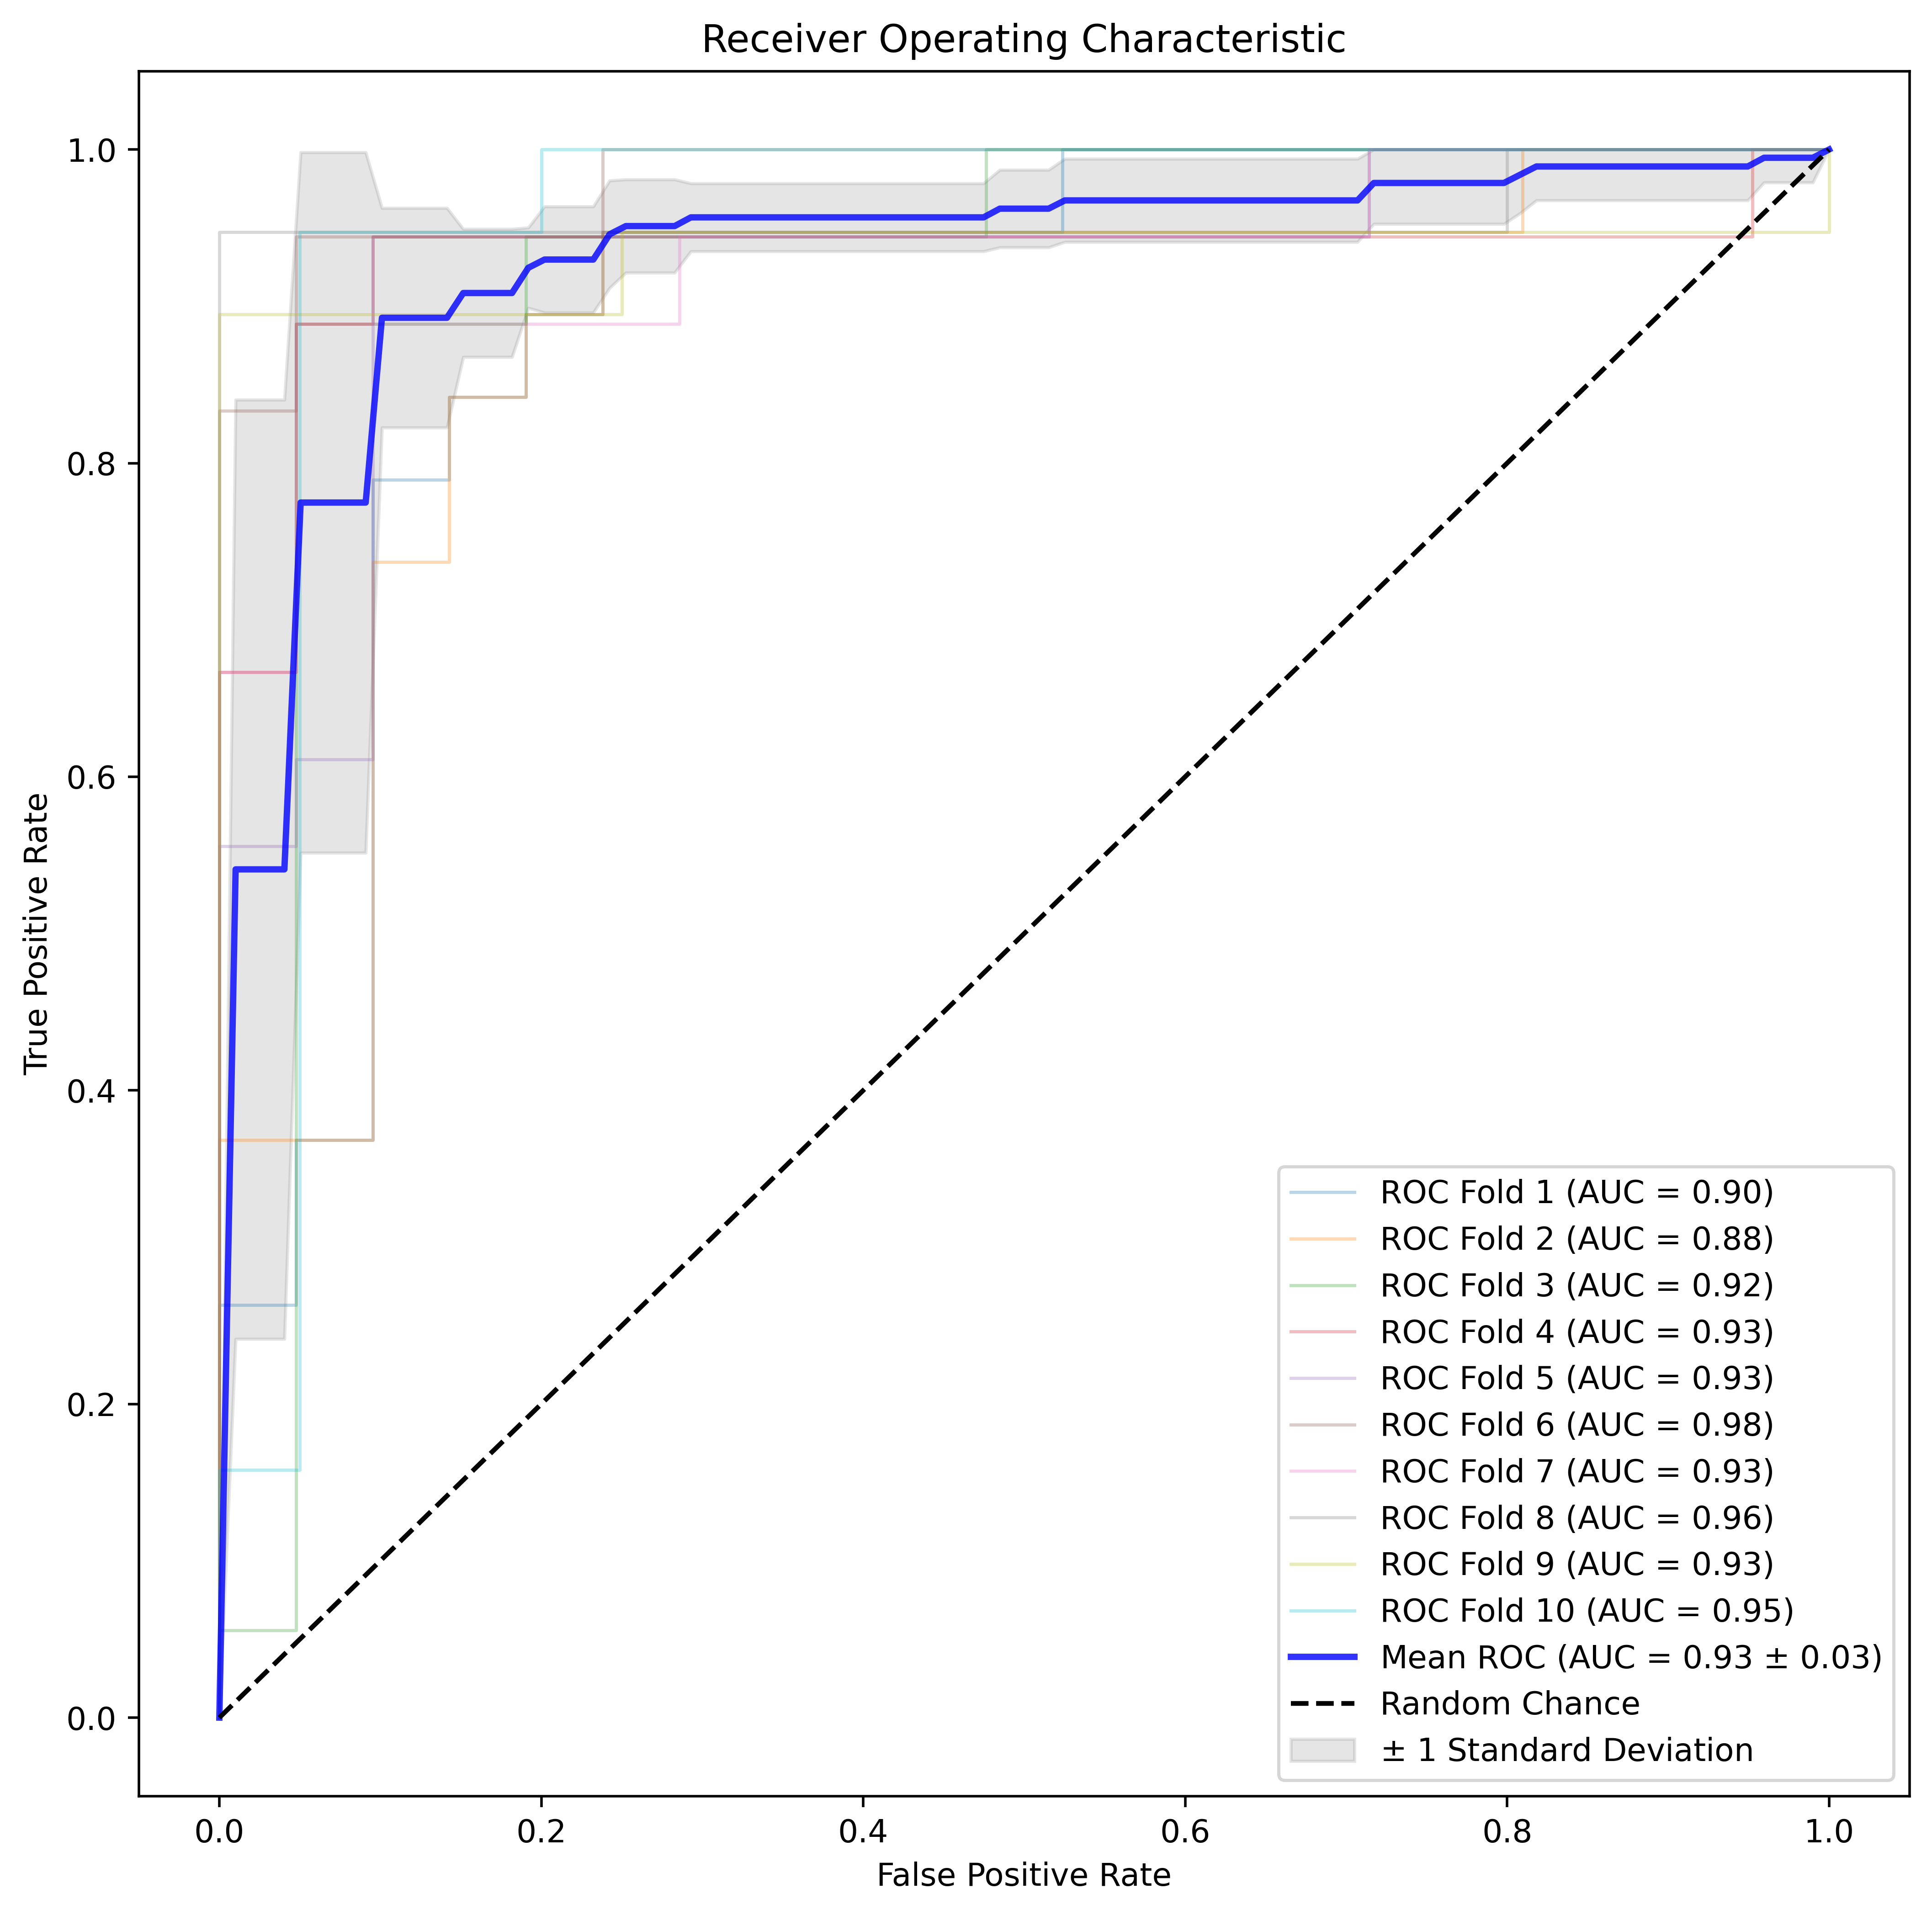

In [17]:
# Plot roc/auc
plot_roc(probas_acf, y_test_acf)

In [ ]:
wake_corrs = np.array([i.corrs for i in wake_acf_class])
nrem_corrs = np.array([i.corrs for i in nrem_acf_class])

corrs = np.vstack((wake_corrs, nrem_corrs))
labels = np.hstack((np.zeros(len(wake_corrs)), np.ones(len(nrem_corrs))))

In [ ]:
km = KMeans(n_clusters=2)
km.fit(corrs)

In [ ]:
true_a = np.where(labels == 0)
true_b = np.where(labels == 1)
clust_a = np.where(km.labels_ == 0)
clust_b = np.where(km.labels_ == 1)

In [ ]:
fig, axes = plt.subplots(nrow=2, ncols=2, figsize=(10, 10))

for i in corrs[true_a]:
    axes[0][0].plot(i, color='k', alpha=.05)
    
for i in corrs[true_b]:
    axes[0][1].plot(i, color='k', alpha=.05)

In [ ]:
plt.figure(0)
for i in corrs[a]:
    plt.plot(i, color='k', alpha=.05)
    
plt.figure(1)
for i in corrs[b]:
    plt.plot(i, color='k', alpha=.05)

In [ ]:
plt.figure(2)
for i in corrs[c]:
    plt.plot(i, color='k', alpha=.05)
    
plt.figure(3)
for i in corrs[d]:
    plt.plot(i, color='k', alpha=.05)
